# FFDI and Thresholding

code is setup to process the intial bias_input_data into FFDI and thresholding.

The FFDI code uses the zarr stores of the individual simulations which requires the rechunking

Thresholding uses the FFDI files of the individual simulations


In [1]:
import sys
import os

import intake
import xarray as xr
from matplotlib import pyplot as plt
import glob
import pathlib
import traceback
from datetime import datetime
from xclim.indices import (
    keetch_byram_drought_index,
    griffiths_drought_factor,
    mcarthur_forest_fire_danger_index
)
from dask.distributed import Client

# Needed for the GWL code
from importlib import reload
# adding folder to the system path
sys.path.insert(0, '/g/data/xv83/rxm599/acs/gwls')

import gwl

In [16]:
# Start Cluster 
import dask
# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

client = Client()
client

2024-06-26 13:46:52,910 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-06-26 13:46:52,918 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-06-26 13:46:52,923 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0181.gadi.nci.org.au/4132/proxy/8787/status,
Dashboard: /node/gadi-cpu-bdw-0181.gadi.nci.org.au/4132/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45551,Workers: 4
Dashboard: /node/gadi-cpu-bdw-0181.gadi.nci.org.au/4132/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:32909,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0181.gadi.nci.org.au/4132/proxy/45785/status,Memory: 0 B
Nanny: tcp://127.0.0.1:44263,


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
files = '/g/data/ia39/ncra/fire/*thresholda.nc'
mRuns = sorted(glob.glob(files))
print(len(mRuns))
print(mRuns[0])

48
/g/data/ia39/ncra/fire/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL1.2_ffdi_thresholda.nc


In [7]:
def extract_model_info(filepath):
    filename = filepath.split('/')[-1]  # Get the filename from the full path
#    filename_no_ext = filename.split('.')[0]  # Remove the file extension
    parts = filename.split('_')  # Split filename by underscores
    print(parts)
    RCM=parts[1]
    GCM=parts[2]
    GWL=parts[8]
    
    # Extract model name
    model_name,extension = os.path.splitext(filename)
    
    match = '_'.join(parts[1:3])  # Extract match (e.g., EC-Earth3_ssp370_r1i1p1f1)
    pathway = parts[3]  # Extract model (e.g., ssp370)
    ensemble = parts[4]  # Extract ensemble (e.g., r1i1p1f1)
    
    return [model_name, extension], RCM, GCM, ensemble, pathway, GWL

In [8]:
def process_threshold(data, time_dim, syear, eyear, var, period):
# first set time slice
    start=str(syear)+'-01-01'
    end=str(eyear)+'-12-31'
    nyear=eyear-syear+1; inyear=1./nyear
    data = data.sel(**{time_dim: slice(start, end)}).persist() # use file chunking .persist()
    print(f"Processing period {period}")
# days over key thresholds (days/yr)
#    d100 = data > 100 ; d100.groupby(time_dim.year).mean
    d3=(data > 100 ).groupby('time.year').sum('time').to_dataset(name='days100')
    d2=(data > 75 ).groupby('time.year').sum('time').to_dataset(name='days75')
    d1=(data > 50 ).groupby('time.year').sum('time').to_dataset(name='days50')
#    d3 = (data > 100).sum('time').to_dataset(name='days100') *inyear
#    d2 = (data > 75).sum('time').to_dataset(name='days75') *inyear
#    d1 = (data > 50).sum('time').to_dataset(name='days50') *inyear
    dss=xr.merge([d1,d2,d3]) 
    return dss

In [9]:
def process_GWL_levels(model_name, GCM, ensemble, pathway, ffdi_data):
    CMIP='CMIP6'
    GWL_levels = ['1.2', '1.5', '2.0', '3.0']
#    GWL_levels = ['1.2']
    for GWL in GWL_levels:
        print(f"Processing GWL {GWL} for model: {GCM}, ensemble: {ensemble}, pathway: {pathway}")
        try:
            start, end = gwl.get_GWL_syear_eyear(CMIP, GCM, ensemble, pathway,GWL= GWL)
        except:
            print(f"No GWL data found for {GWL}")
            continue
        ffdi_data=xr.open_zarr('/g/data/ia39/ncra/fire2/'+model_name+'_FFDI.zarr')
        d4 = process_threshold(ffdi_data.FFDI, 'time', start, end, 'FFDI', GWL)
        output_path = f'/g/data/ia39/ncra/fire/{model_name}_GWL{GWL}_ffdi_thresholda.nc'
        print(f"Saved  to {output_path}")
        d4.to_netcdf(output_path)
    return d4

In [ ]:
%%time
# iterate through all modesl
for mindex, file in enumerate(mRuns):
#    print(file)
    model_name, RCM, GCM, ensemble, pathway, gwl = extract_model_info(file)
    var='FFDI'  # not used
#    if mindex != 1:         #this model failed to convert
    if mindex <= 651:         #this model failed to convert
        print (mindex,gwl,model_name[0])
        ds=xr.open_dataset(file)
        pq1=ds.days50.quantile((.90,.50,.10), dim='year').persist()
        pq2=ds.days75.quantile((.90,.50,.10), dim='year').persist()
        pq3=ds.days100.quantile((.90,.50,.10), dim='year').persist()
        dss=xr.merge([pq1,pq2,pq3]) 
        dss.to_netcdf('/scratch/xv83/rxm599/'+model_name[0]+'_'+ gwl +'_pq.nc',mode='w')
        if mindex == 0:
            da=dss
        else:
            da=[da,dss]
 
        
print("Processing of all catalogues is complete.")
dnew=xr.combine_nested(da, concat_dim=["gwl"])
dnew.assign_coords({"gwl":['GWL1.2','GWL1.5']}) 

['AGCD-05i', 'BOM', 'ACCESS-CM2', 'ssp370', 'r4i1p1f1', 'BARPA-R', 'v1-r1', 'day', 'GWL1.2', 'ffdi', 'thresholda.nc']
0 GWL1.2 AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL1.2_ffdi_thresholda
['AGCD-05i', 'BOM', 'ACCESS-CM2', 'ssp370', 'r4i1p1f1', 'BARPA-R', 'v1-r1', 'day', 'GWL1.5', 'ffdi', 'thresholda.nc']
1 GWL1.5 AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL1.5_ffdi_thresholda
['AGCD-05i', 'BOM', 'ACCESS-CM2', 'ssp370', 'r4i1p1f1', 'BARPA-R', 'v1-r1', 'day', 'GWL2.0', 'ffdi', 'thresholda.nc']
2 GWL2.0 AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL2.0_ffdi_thresholda


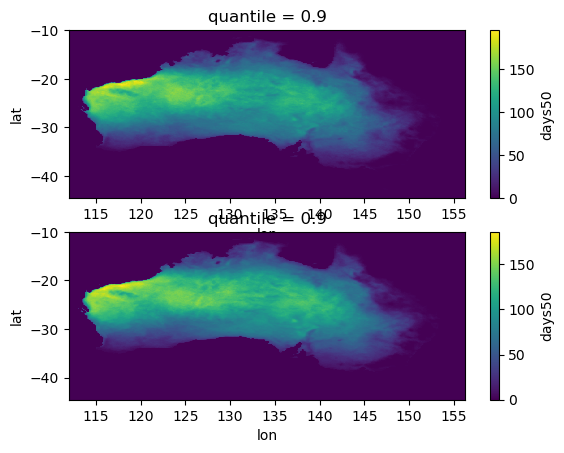

In [19]:
plt.subplot(2,1,1); dnew.days50[1,0,:,:].plot()
plt.subplot(2,1,2); dnew.days50[0,0,:,:].plot()

In [20]:
print(mRuns[0],mRuns[1])

/g/data/ia39/ncra/fire/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL1.2_ffdi_thresholda.nc /g/data/ia39/ncra/fire/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day_GWL1.5_ffdi_thresholda.nc


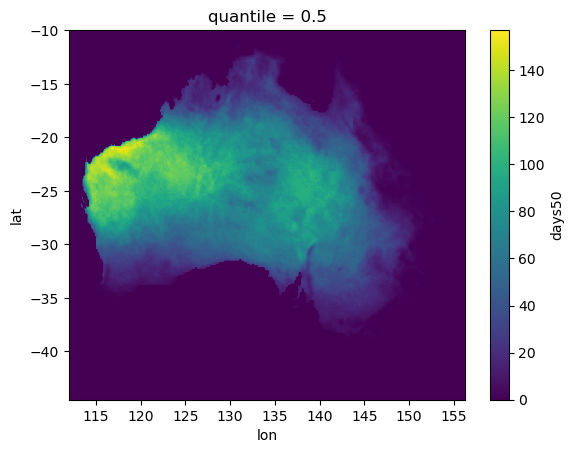

In [21]:
pq=ds.days50.quantile((.90,.50,.10), dim='year').persist()
pq[1,:,:].plot()
pq.to_netcdf('/scratch/xv83/rxm599/pq.nc)

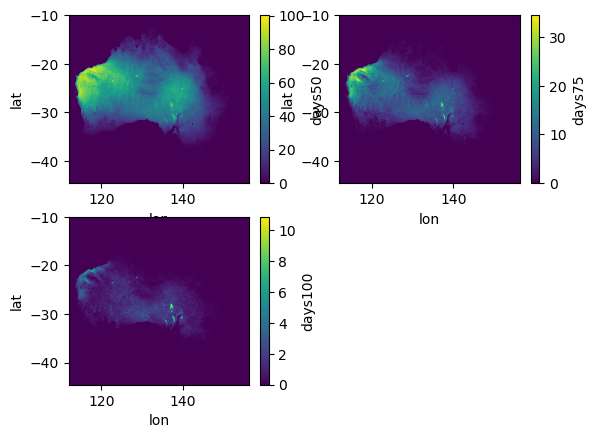

In [16]:
plt.subplot(2,2,1); d4.days50.plot()
plt.subplot(2,2,2); d4.days75.plot()
plt.subplot(2,2,3); d4.days100.plot()

In [67]:
ds

<xarray.Dataset> Size: 294MB
Dimensions:  (lat: 691, lon: 886, year: 20)
Coordinates:
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
  * year     (year) int64 160B 2018 2019 2020 2021 2022 ... 2034 2035 2036 2037
Data variables:
    days50   (lat, lon, year) float64 98MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    days75   (lat, lon, year) float64 98MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    days100  (lat, lon, year) float64 98MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [ ]:
dnew=

In [ ]:
for mindex, file in enumerate(mRuns):
    print(file)

    
#    process_GWL_levels(model_name, model, ensemble, pathway, ffdi_data)

print("Processing of all catalogues is complete.")
client.close()

In [15]:
client.close()